<a href="https://colab.research.google.com/github/abhinavawasthi1729/Social-distancing-analysis/blob/main/Social_distancing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


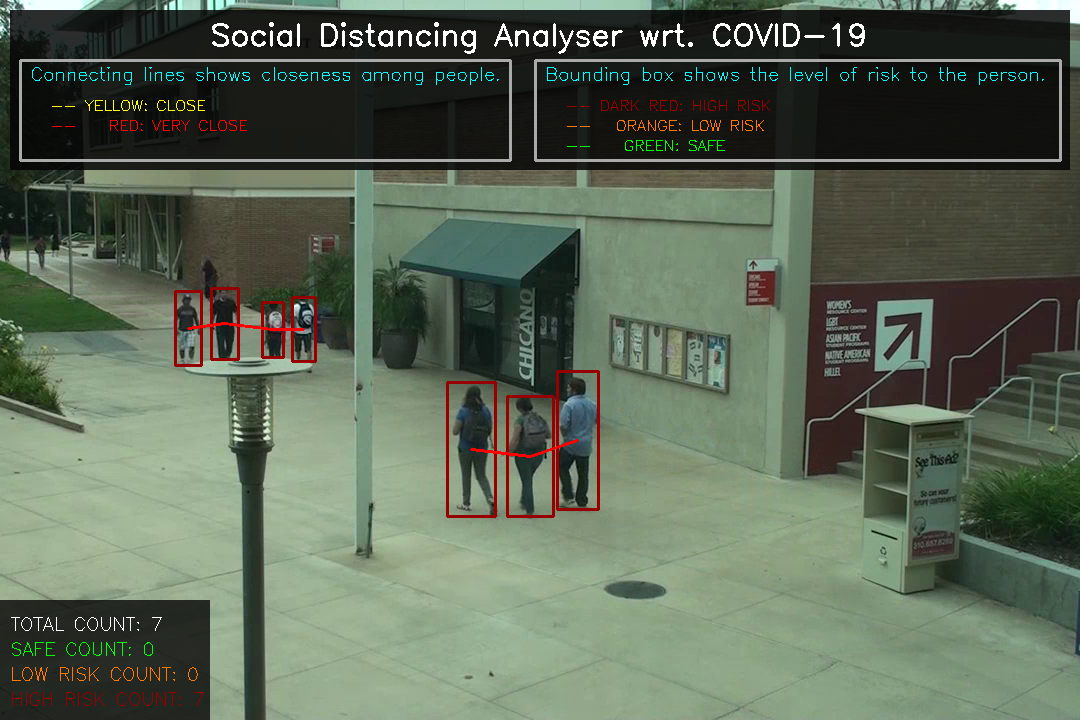

KeyboardInterrupt: ignored

In [11]:
%matplotlib inline
import time
#from bokeh.plotting import figure
#from bokeh.io import output_notebook, show, push_notebook
import cv2
import numpy as np
#from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
#from IPython.display import clear_output
from time import sleep
#output_notebook()

confid = 0.5
thresh = 0.5

vid_path = "/gdrive/MyDrive/Social-Distancing-Analyser-COVID-19-master/videos/video.mp4"


# Calibration needed for each video

def calibrated_dist(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + 550 / ((p1[1] + p2[1]) / 2) * (p1[1] - p2[1]) ** 2) ** 0.5


def isclose(p1, p2):
    c_d = calibrated_dist(p1, p2)
    calib = (p1[1] + p2[1]) / 2
    if 0 < c_d < 0.15 * calib:
        return 1
    elif 0 < c_d < 0.2 * calib:
        return 2
    else:
        return 0


labelsPath = "/gdrive/MyDrive/Social-Distancing-Analyser-COVID-19-master/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

np.random.seed(42)

weightsPath = "/gdrive/MyDrive/Social-Distancing-Analyser-COVID-19-master/yolov3.weights"
configPath = "/gdrive/MyDrive/Social-Distancing-Analyser-COVID-19-master/yolov3.cfg"

###### use this for faster processing (caution: slighly lower accuracy) ###########

# weightsPath = "./yolov3-tiny.weights"  ## https://pjreddie.com/media/files/yolov3-tiny.weights
# configPath = "./yolov3-tiny.cfg"       ## https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg


net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

vs = cv2.VideoCapture(vid_path)
writer = None
(W, H) = (None, None)

fl = 0
q = 0
while True:

    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]
        q = W

    frame = frame[0:H, 200:q]
    (H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:

        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if LABELS[classID] == "person":

                if confidence > confid:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confid, thresh)

    if len(idxs) > 0:

        status = list()
        idf = idxs.flatten()
        close_pair = list()
        s_close_pair = list()
        center = list()
        dist = list()
        for i in idf:
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            center.append([int(x + w / 2), int(y + h / 2)])

            status.append(0)
        for i in range(len(center)):
            for j in range(len(center)):
                g = isclose(center[i], center[j])

                if g == 1:

                    close_pair.append([center[i], center[j]])
                    status[i] = 1
                    status[j] = 1
                elif g == 2:
                    s_close_pair.append([center[i], center[j]])
                    if status[i] != 1:
                        status[i] = 2
                    if status[j] != 1:
                        status[j] = 2

        total_p = len(center)
        low_risk_p = status.count(2)
        high_risk_p = status.count(1)
        safe_p = status.count(0)
        kk = 0

        for i in idf:

            sub_img = frame[10:170, 10:W - 10]
            black_rect = np.ones(sub_img.shape, dtype=np.uint8) * 0

            res = cv2.addWeighted(sub_img, 0.77, black_rect, 0.23, 1.0)

            frame[10:170, 10:W - 10] = res

            cv2.putText(frame, "Social Distancing Analyser wrt. COVID-19", (210, 45),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.rectangle(frame, (20, 60), (510, 160), (170, 170, 170), 2)
            cv2.putText(frame, "Connecting lines shows closeness among people. ", (30, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)
            cv2.putText(frame, "-- YELLOW: CLOSE", (50, 110),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
            cv2.putText(frame, "--    RED: VERY CLOSE", (50, 130),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            cv2.rectangle(frame, (535, 60), (W - 20, 160), (170, 170, 170), 2)
            cv2.putText(frame, "Bounding box shows the level of risk to the person.", (545, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1)
            cv2.putText(frame, "-- DARK RED: HIGH RISK", (565, 110),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 150), 1)
            cv2.putText(frame, "--   ORANGE: LOW RISK", (565, 130),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 120, 255), 1)

            cv2.putText(frame, "--    GREEN: SAFE", (565, 150),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            tot_str = "TOTAL COUNT: " + str(total_p)
            high_str = "HIGH RISK COUNT: " + str(high_risk_p)
            low_str = "LOW RISK COUNT: " + str(low_risk_p)
            safe_str = "SAFE COUNT: " + str(safe_p)

            sub_img = frame[H - 120:H, 0:210]
            black_rect = np.ones(sub_img.shape, dtype=np.uint8) * 0

            res = cv2.addWeighted(sub_img, 0.8, black_rect, 0.2, 1.0)

            frame[H - 120:H, 0:210] = res

            cv2.putText(frame, tot_str, (10, H - 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            cv2.putText(frame, safe_str, (10, H - 65),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
            cv2.putText(frame, low_str, (10, H - 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 120, 255), 1)
            cv2.putText(frame, high_str, (10, H - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 150), 1)

            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            if status[kk] == 1:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 150), 2)

            elif status[kk] == 0:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            else:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 120, 255), 2)

            kk += 1
        for h in close_pair:
            cv2.line(frame, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)
        for b in s_close_pair:
            cv2.line(frame, tuple(b[0]), tuple(b[1]), (0, 255, 255), 2)

        #cv2.imshow('Social distancing analyser', frame)
        clear_output()
        cv2_imshow(frame)
        sleep(0.1)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("output.mp4", fourcc, 30,
                                 (frame.shape[1], frame.shape[0]), True)

    writer.write(frame)
print("Processing finished: open output.mp4")
writer.release()
vs.release()
